In [232]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [233]:
def f(x):
    return 3 * x**2 - 4 * x + 5

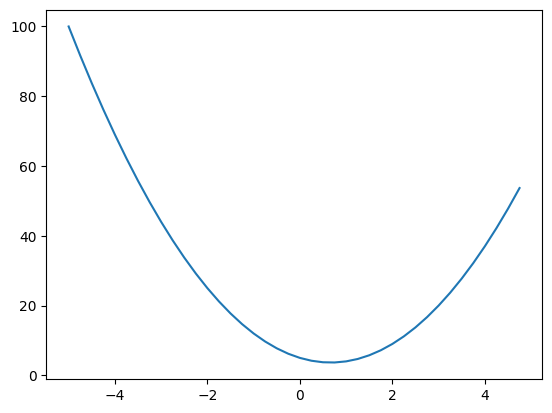

In [234]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [235]:
# Obliczanie pochodnej numerycznej
h = 0.0000000001  # mała wartość przyrostu
x = 3
(
    f(x + h) - f(x)
) / h  # jest to wartość bardzo zbliżona do pochodnej rzeczywiste czyli 6x - 4  f(x) = 6 * 3 - 4 = 18 - 4 = 14

14.000001158365194

In [236]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [237]:
h = 0.0001

# inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print(f"d1 {d1}")
print(f"d2 {d2}")
print(f"slope: {(d2 - d1) / h}")

d1 4.0
d2 3.999699999999999
slope: -3.000000000010772


In [238]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), "-")

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad = round((1 - t**2), 2) * out.grad

        out._backward = _backward
        return out


    def backward(self):

        visited = set()
        topo = []

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()




a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
f = Value(-2.0, label="f")
d = e + c
d.label = "d"
L = d * f
L.label = "L"
L

# d._prev
# d._op czyli d powstało z operacji dodawania
# a + b # python wywoła metodę taką a.__add__(b)

# a*b + c # python wywoła taką metodę: (a.__mul__(b)).__add__(c) - mogę to także ręcznie wywołać

Value(data=-8.0)

In [239]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{ %s | data  %.4f} | grad %.4F " % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)), n2._op)

    return dot

In [240]:
L.grad = 1.0

# wizualizacja przejścia w przód

# ! Teraz co będę robił to propagacja wsteczna. W przypadku propagacji wstecznej
# * zaczynamy od tyłu i obliczymy gradient wzdłuż wszystich tych wartości
# * to co będziemy obliczać dla pojedyńczego węzła to pochodna względm L
# TODO

# * grad reprezntuje pochodną wyniku

In [241]:
L = d * f  # * chcielibymśy poznać dL/dd = ? f

# * (f(x+h) - f(x))/h
# * ((d+h)*f - d*f)/h
# * (d*f + h*f - d*f)/h
# * (h*f)/h ==> f

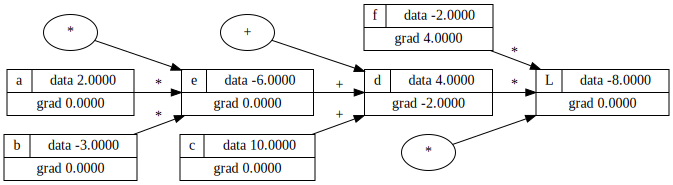

In [242]:
f.grad = 4.0
d.grad = -2.0
L.label = "L"

draw_dot(L)

In [243]:
# * Obliczanie pochodnej funkcji L = d * f względem f
def loc():
    h = 0.000001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    f = Value(-2.0, label="f")
    d = e + c
    d.label = "d"
    L = d * f
    L.label = "L"
    L1 = L.data

    # * y = a*b + c

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    f = Value(-2.0, label="f")
    d = e + c
    d.label = "d"
    d = Value(d.data + h)  # * względem d ponieważ dodaje do niej przyrost
    L = d * f
    L.label = "L"
    L2 = L.data

    print((L2 - L1) / h)


loc()

-2.000000000279556


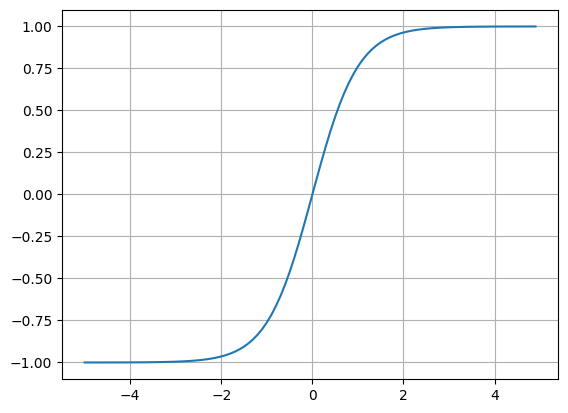

In [244]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1)))
plt.grid()

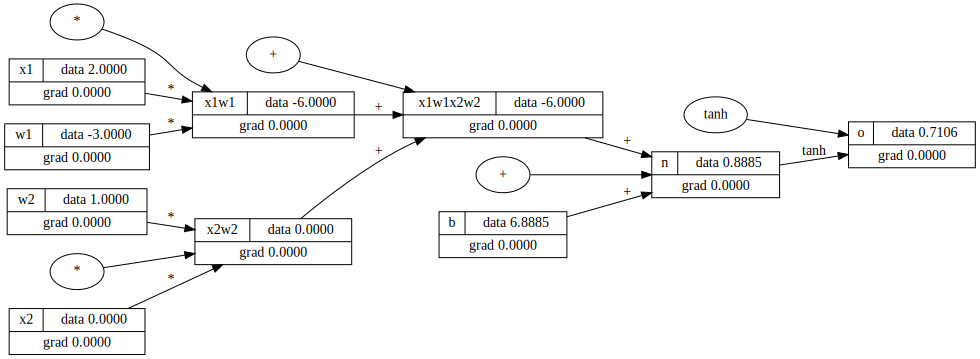

In [245]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.88845675466464, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b
n.label = "n"  # cell body (aktywacja komórki)

o = n.tanh()
o.label = "o"

draw_dot(o)

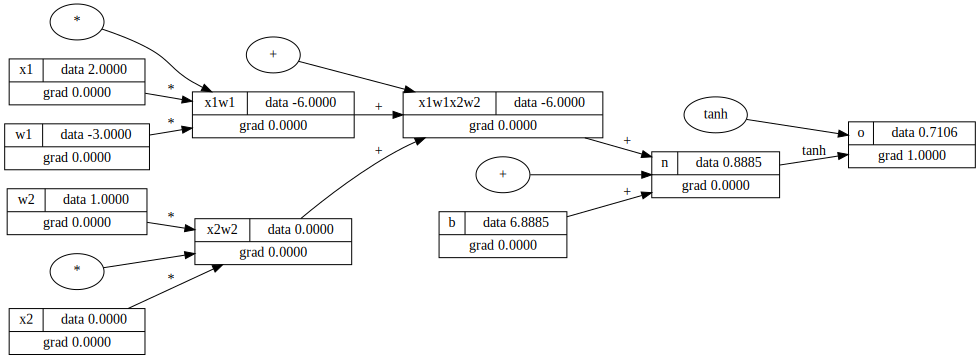

In [246]:
o.grad = 1.0
draw_dot(o)

In [247]:
# Propagacja wsteczna

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
# n.grad = 1 - o.data**2 (w przybliżeniu to jest 0.5) wiec zapiszemy, n.grad = 0.5

n.grad = 0.5

# gradient starty względem b
# Ponieważ n = b + x1w1x2w2 pochodna względem b jest prosta dn/db = 1
# Zatem używając reguły łańcuchowj (chain rule)
# do/db = do/dn * dn/db = 0.495 * 1 = 0.495

# gradient względem x1w1x2w2
# ponieważ n = b + x1w1x2w2 pochodna względem x1w1x2w2 wynosi 1 dn/dx1w1x2w2
# zatem do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = 0.495 * 1 = 0.495

b.grad = 0.5
x1w1x2w2.grad = 0.5


x1w1.grad = 0.5
x2w2.grad = 0.5

# x1.grad = -1.5
# w1.grad = 1.0

# x2.grad = 0.5
# w2.grad = 0


x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x1w1.grad
w2.grad = x2.data * x1w1.grad

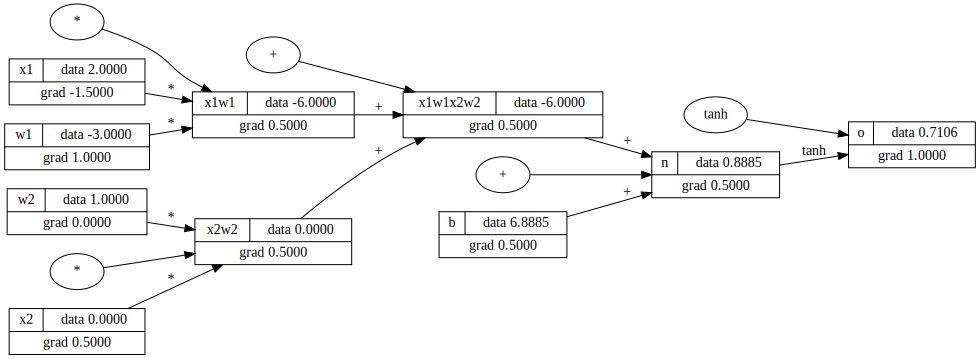

In [248]:
draw_dot(o)

In [249]:
# Liczymy pochodną względem x1w1 zatem do/dx1w1
# ponieważ pochodna x1w1x2w2 = x1w1 + x2w2 czyli dx1w1x2w2/x1w1 = x1w1 + x2w2 = 1
# do/x1w1 = do/x1w1x2w2 * dx1w1x2w2/x1w1 = 0.5 * 1 = 0.5

# Pochodna względem x2w2 do/dx2w2
# pochodna x1w1x2w2 = x1w1 + x2w2 = dx1w1x2w2/dx2w2 = 1
# do/x2w2 = do/x1w1x2w2 * dx1w1x2w2/x2w2 = 0.5 * 1 = 0.5


# Liczymy pochodną względem x1 zatem do/x1
# ponieważ pochodna x1w1 = x1 * w1 czyli dx1w1/x1 = x1 * w1 = w1
# do/x1 = do/x1w1 * dx1w1/x1 = 0.5 * w1 = 0.5 * -3.0 = -1.5

# Liczymy pochodną względem w1 zatem do/w1
# ponieważ pochodna x1w1 = x1 * w1 --> dx1w1/w1 = x1
# do/w1 = do/x1w1 * dx1w1/w1 = 0.5 * x1 = 0.5 * 2 = 1.0


# Liczymy pochodną względem x2 zatem do/x2
# x2w2 = x2 * w2 zatem dx2w2/x2 = w2
# do/x2 = do/x2w2 * dx2w2/x2 = 0.5 * w2 = 0.5 * 1 = 0.5

# Liczymy pochodną względem w2 zatem do/w2
# x2w2 = x2 * w2 zatem dx2w2/w2 = x2
# do/w2 = do/x2w2 * dx2w2/w2 = 0.5 * x2 = 0

In [250]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.88845675466464, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b
n.label = "n"  # cell body (aktywacja komórki)

o = n.tanh(); o.label = 'o'
o.grad = 1.0

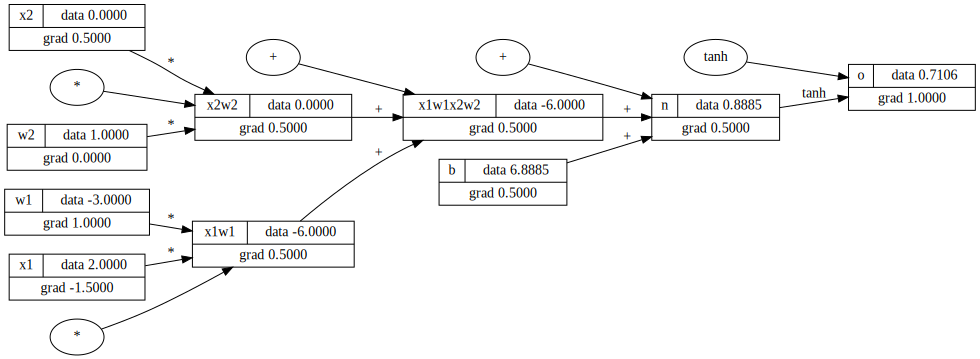

In [251]:
o._backward()

n.grad = 0.5

n._backward()


x1w1x2w2._backward()


x1w1._backward()

x2w2._backward()

draw_dot(o)



In [252]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.88845675466464, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b
n.label = "n"  # cell body (aktywacja komórki)

o = n.tanh(); o.label = 'o'



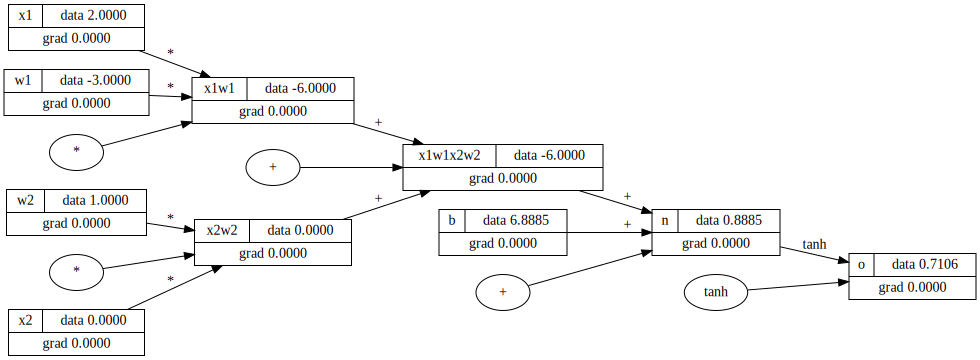

In [253]:
draw_dot(o)



In [254]:
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)


# for node in reversed(topo):
#     node._backward()

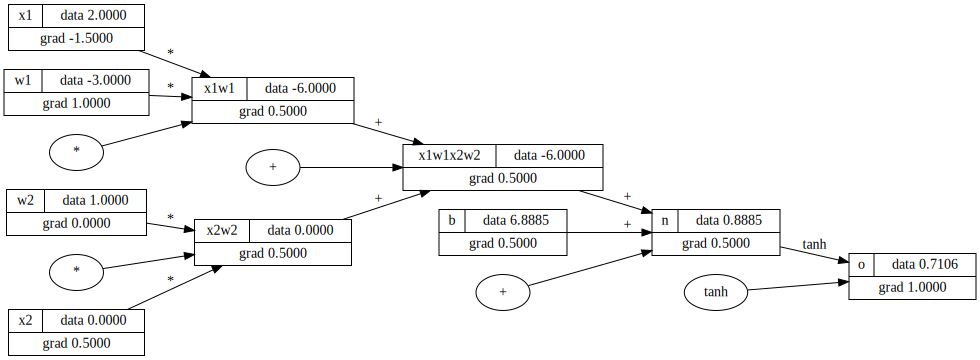

In [255]:
o.backward()
draw_dot(o)

